# [04] COVID 이미지 분류

`01-03`까지의 완성해본 노트북을 통해서 이미지 분류 작업을 완성해보겠습니다.


In [1]:
import torch
from materials.mobilenetv2 import mobilenet_v2
from materials.stat_image import _get_mean, _get_var

In [ ]:
from torchvision import datasets, transforms
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
import matplotlib.pyplot as plt

# Transform 함수

아래는 만들었던 directory에서 파일 정보를 불러와서 `dataset & dataloader`를 만듭니다.

전이(Transform)를 적용한 dataset을 만들기 위해서 만들 것입니다.

Pytorch에서 Dataset의 샘플링은 다음과 같이 됩니다.

- 이미지는 파일 전체를 메모리에 올리지않고 필요할 때마다 불러와서 읽습니다.
- 그 후, 불러온 이미지에 만들어둔 Transform을 적용합니다.
- Transform 중 하나가 랜덤이기 때문에, 데이터는 샘플링 때 증가합니다.

Q) 같은 순서의 이미지 파일을 불러오면, 불러온 정보는 같은 정보일까요?

- datasets.ImageFolder: 정해진 폴더 디렉토리의 데이터를 불러옵니다.
- torch.utils.data.Dataloader: 만들어진 dataset을 batch단위로 묶어줍니다.
- SubsetRandomSampler: dataset의 리스트 중엣서 정해진 index의 데이터로 새롭게 재구성합니다. 이는 valid set을 만들기 위함입니다.

`torchvision` 패키지는 몇몇의 커스텀 데이터셋과 전이(transforms)를 제공합니다.

torchvision에서 사용가능한 일반적인 데이터 셋은 `Imagefolder`입니다.

`01`에서와 같은 데이터 구성은 `Imagefolder`의 사용을 가능하게 합니다.

In [2]:
def load_split_train_valid(datadir, valid_size = .2):
    train_data = datasets.ImageFolder(?????????,       
                    transform=data_transforms['train']) #Picks up Image Paths from its respective folders and label them
    valid_data = datasets.ImageFolder((?????????,,
                    transform=data_transforms['val'])
    
    num_train = len(train_data)
    indices = list(range(num_train))
    
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    train_idx, valid_idx = indices[split:], indices[:split]
    dataset_size = {"train":len(train_idx), "val":len(valid_idx)}
    
    train_sampler = SubsetRandomSampler(train_idx) # Sampler for splitting train and val images
    valid_sampler = SubsetRandomSampler(valid_idx)
    
    trainloader = torch.utils.data.DataLoader(??????????????) # DataLoader provides data from traininng and validation in batches
    validloader = torch.utils.data.DataLoader(??????????????)
    
    return trainloader, validloader, dataset_size

In [3]:
path = './COVID19-DATASET/train/'

In [4]:
mean = _get_mean(path)
var = _get_var(path)

## Transforms

우리가 만들고자 하는 신경망은 고정된 크기의 이미지를 입력으로 받게 만듭니다.

여기서 몇가지의 `transforms`함수를 만들어볼 것입니다.

- `Resize`, `RandomRotation`, `RandomHorizontalFlip`, `ToTensor`, `Normalize`입니다. 각각은 아래와 같습니다.
- `Resize`는 이미지의 크기를 고정된 크기로 만들어주기 위함입니다.
- `RandomRotation`은 이미지를 최대 10도를 랜덤으로 돌리는 함수 입니다.
- `RandomHorizontalFlip`은 수평으로 일정한 확률로 뒤집어주는 함수 입니다.
- `ToTensor`는 0과 1 사이의 값을 갖는 tensor로 변환시켜주는 함수입니다.
- `Normalize`는 정해진 mean, var를 통해 데이터를 normalize하는 함수입니다. (픽셀 단위로)

In [7]:
data_transforms = {"train":transforms.Compose([
                                ?????????, 
                                ?????????, 
                                ?????????,
                                ?????????, 
                                ?????????,
                        ]),
                   "val": transforms.Compose([
                                ?????????,
                                ?????????, 
                                ?????????,
                                ?????????
                    ])}

In [15]:
trainloader, valloader, dataset_size = load_split_train_test(path, .2)
dataloaders = {"train":trainloader, "val":valloader}
data_sizes = {x: len(dataloaders[x].sampler) for x in ['train','val']}
class_names = trainloader.dataset.classes
print(class_names)

['covid19', 'normal']


만들어준 데이터를 다시 시각화하기 위한 함수입니다.

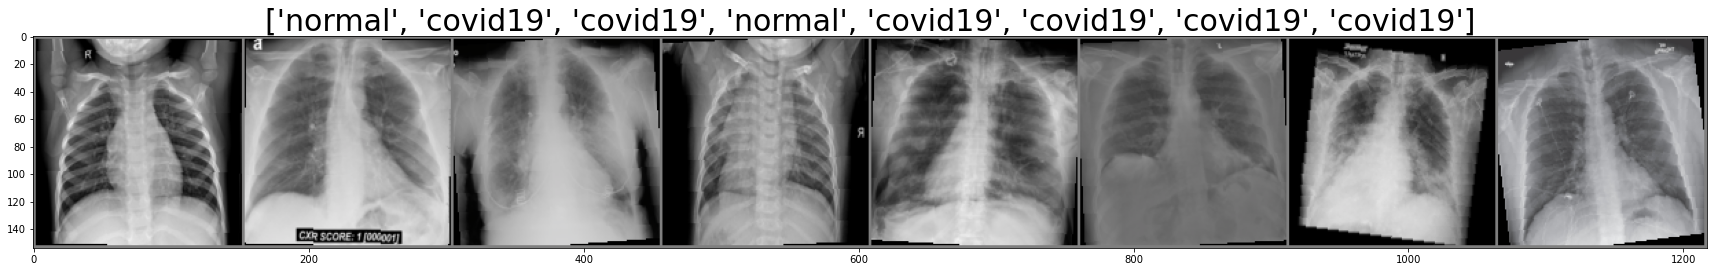

In [22]:
def imshow(inp, mean, std, size =(30,30), title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = ???????? # normalize 전으로 바꾸기
    inp = np.clip(inp, 0, 1) 
    plt.figure(figsize=size)
    plt.imshow(inp)
    if title is not None:
        plt.title(title, size=30)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, mean, var, title=[class_names[x] for x in classes])

torch에서 gpu를 통해 학습을 하기 위함입니다.

In [23]:
if torch.cuda.is_available():
    device=torch.device("cuda:0")
    print("Training on GPU... Ready for HyperJump...")
else:
    device = torch.device("cpu")
    print("Training on CPU... May the force be with you...")

Training on GPU... Ready for HyperJump...


In [24]:
model = mobilenet_v2(pretrained=True)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /home/taehyeon/.cache/torch/checkpoints/mobilenet_v2-b0353104.pth


만약에 Transfer learning을 원한다면 아래의 옵션을 추가하세요.

    for params in model.parameters():
        params.requires_grad = False
        
Q) 이것의 의미는 무엇일까요? 더 세분화하여서 해볼 수는 없을까요? (정교하게)

In [29]:
import torch.nn as nn

Q) 왜 아래와 같은 작업을 하는 것일까요?

Q) 위의 답을 했다면, 왜 classifier로는 nn.Linear하나만을 사용하여야 하는 가요?

In [30]:
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, len(class_names))
model = model.to(device)

In [31]:
import torch.optim as optim

Q) optimizer와 scheduler는 다른 것들을 사용할 수 있을까요?

In [32]:
# loss function은 categorical loss에 적합한 cross-entropy loss 를 사용
criterion = nn.CrossEntropyLoss()

# optimizer로는 일반적으로 수렴 속도가 빠른 것으로 알려진 Adam 사용
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# LR은 exponential decay를 사용.
# step size를 7로 두어 7마다 0.1(gamma)씩 decay하게 만듬
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1) # Learning Scheduler

In [33]:
# 전체 parameter의 개수
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters: \n{}".format(pytorch_total_params))

Number of trainable parameters: 
2226434


## 최종: 신경망 train 함수 만들기

In [40]:
import time
import copy
import tqdm

from sklearn.metrics import accuracy_score, cohen_kappa_score

데이터 상에서 반복하는 for문은 많은 특징(features)를 놓칠 수 있습니다. (특히 아래의 것들)

- 데이터를 묶는 과정
- 데이터를 섞는 과정
- 병렬처리 과정에서 multiprocessing을 사용할 때 데이터를 불러오는 것

`torch.utils.data.DataLoader`는 위와 같은 기능을 모두 제공해주는 반복자(iterator)입니다.


In [41]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            current_loss = 0.0
            current_corrects = 0
            current_kappa = 0
            val_kappa = list()

            for inputs, labels in tqdm.tqdm(dataloaders[phase], desc=phase, leave=True):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # We need to zero the gradients in the Cache.
                optimizer.zero_grad()

                # Time to carry out the forward training poss
                # We only need to log the loss stats if we are in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                if phase == 'train':
                    scheduler.step()

                # We want variables to hold the loss statistics
                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels.data)
                val_kappa.append(cohen_kappa_score(preds.cpu().numpy(), labels.data.cpu().numpy()))
            epoch_loss = current_loss / data_sizes[phase]
            epoch_acc = current_corrects.double() / data_sizes[phase]
            if phase == 'val':
                epoch_kappa = np.mean(val_kappa)
                print('{} Loss: {:.4f} | {} Accuracy: {:.4f} | Kappa Score: {:.4f}'.format(
                    phase, epoch_loss, phase, epoch_acc, epoch_kappa))
            else:
                print('{} Loss: {:.4f} | {} Accuracy: {:.4f}'.format(
                    phase, epoch_loss, phase, epoch_acc))

            # EARLY STOPPING
            if phase == 'val' and epoch_loss < best_loss:
                print('Val loss Decreased from {:.4f} to {:.4f} \nSaving Weights... '.format(best_loss, epoch_loss))
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val loss: {:.4f}'.format(best_loss))

    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    return model

In [45]:
def visualize_model(model, mean, var, num_images=6):
    was_training = model.training
    model.eval()
    images_handeled = 0
    ax = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
    
            for j in range(inputs.size()[0]):
                images_handeled += 1    
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('Actual: {} predicted: {}'.format(class_names[labels[j].item()],class_names[preds[j]]))
                imshow(inputs.cpu().data[j], mean, var, (5,5))

                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [43]:
base_model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=10)

train:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 1/10
----------


val:   0%|          | 0/16 [00:00<?, ?it/s]

train Loss: 0.2033 | train Accuracy: 0.9342


val:  94%|█████████▍| 15/16 [00:03<00:00,  5.06it/s]/home/taehyeon/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
train:   0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.0479 | val Accuracy: 0.9917 | Kappa Score: nan
Val loss Decreased from inf to 0.0479 
Saving Weights... 

Epoch 2/10
----------


val:   0%|          | 0/16 [00:00<?, ?it/s]

train Loss: 0.1625 | train Accuracy: 0.9403


train:   0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.0391 | val Accuracy: 0.9835 | Kappa Score: nan
Val loss Decreased from 0.0479 to 0.0391 
Saving Weights... 

Epoch 3/10
----------


val:   6%|▋         | 1/16 [00:00<00:02,  5.58it/s]

train Loss: 0.1781 | train Accuracy: 0.9444


train:   0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.0450 | val Accuracy: 0.9917 | Kappa Score: nan

Epoch 4/10
----------


val:   0%|          | 0/16 [00:00<?, ?it/s]

train Loss: 0.2710 | train Accuracy: 0.9177


train:   0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.0402 | val Accuracy: 0.9835 | Kappa Score: nan

Epoch 5/10
----------


val:   0%|          | 0/16 [00:00<?, ?it/s]

train Loss: 0.1497 | train Accuracy: 0.9588


train:   0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.0446 | val Accuracy: 0.9917 | Kappa Score: nan

Epoch 6/10
----------


val:   0%|          | 0/16 [00:00<?, ?it/s]

train Loss: 0.1167 | train Accuracy: 0.9588


train:   2%|▏         | 1/61 [00:00<00:10,  5.79it/s]

val Loss: 0.0559 | val Accuracy: 0.9917 | Kappa Score: nan

Epoch 7/10
----------


val:   0%|          | 0/16 [00:00<?, ?it/s]

train Loss: 0.1058 | train Accuracy: 0.9671


train:   0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.0388 | val Accuracy: 0.9835 | Kappa Score: nan
Val loss Decreased from 0.0391 to 0.0388 
Saving Weights... 

Epoch 8/10
----------


val:   0%|          | 0/16 [00:00<?, ?it/s]

train Loss: 0.1800 | train Accuracy: 0.9444


train:   0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.0410 | val Accuracy: 0.9917 | Kappa Score: nan

Epoch 9/10
----------


val:   0%|          | 0/16 [00:00<?, ?it/s]

train Loss: 0.1430 | train Accuracy: 0.9527


train:   0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.0427 | val Accuracy: 0.9917 | Kappa Score: nan

Epoch 10/10
----------


val:   6%|▋         | 1/16 [00:00<00:02,  6.86it/s]

train Loss: 0.1886 | train Accuracy: 0.9506


val: 100%|██████████| 16/16 [00:03<00:00,  4.89it/s]

val Loss: 0.0542 | val Accuracy: 0.9917 | Kappa Score: nan

Training complete in 3m 15s
Best val loss: 0.0388


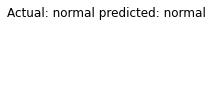

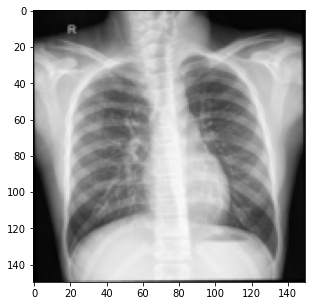

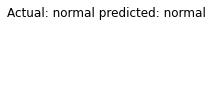

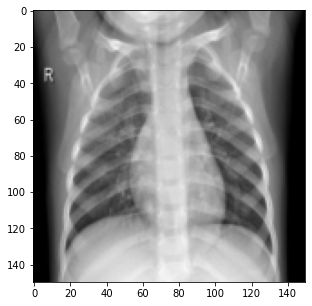

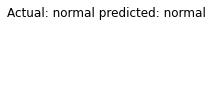

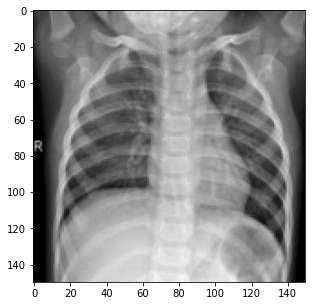

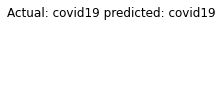

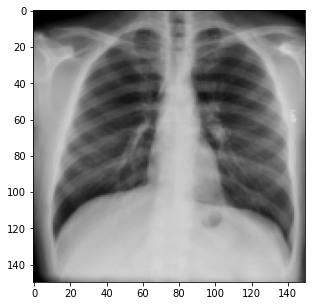

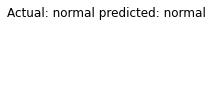

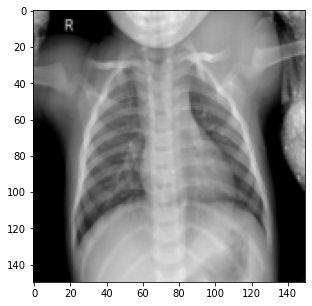

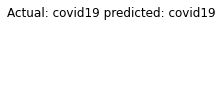

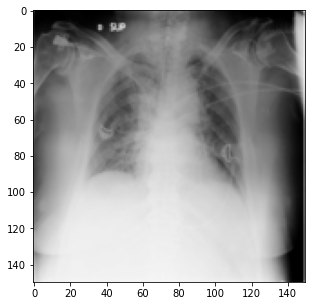

In [47]:
visualize_model(base_model, mean, var)
plt.show()

In [48]:
torch.save(base_model.state_dict(), './best_model.pth')

---------
### <생각해 봅시다>

- 중간 중간의 질문들에 대하여 답하여 보며, 정확도나 다른 성능을 최대한 올려보세요.
- Transfer learning과 Training을 다르게 하여보세요.
- 사전자료를 활용하여서, Confusion Matrix를 뽑아보세요.

------------